# 인공지능 팀 프로젝트

Title : Regression 알고리즘을 이용한 데이터 분석

Objective 1 : 중고차 가격 예측

Objective 2 : 보험료 가격 예측

# 중고차 가격 예측

In [103]:
from google.colab import drive
import os, sys
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [104]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Datasets

In [105]:
from __future__ import print_function
import os
data_path = ['/content/gdrive/MyDrive/Colab Notebooks/2022-AI-W13']

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler


In [106]:
import pandas as pd
import numpy as np

# Import the data using the file path
filepath = os.sep.join(data_path + ['car data.csv'])
data = pd.read_csv(filepath, sep=',')

print(data.shape)

(301, 9)


In [107]:
data.dtypes

Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Driven_kms         int64
Fuel_Type         object
Selling_type      object
Transmission      object
Owner              int64
dtype: object

In [108]:
data.head(5).T

,0,1,2,3,4
Car_Name,ritz,sx4,ciaz,wagon r,swift
Year,2014,2013,2017,2011,2014
Selling_Price,3.35,4.75,7.25,2.85,4.6
Present_Price,5.59,9.54,9.85,4.15,6.87
Driven_kms,27000,43000,6900,5200,42450
Fuel_Type,Petrol,Diesel,Petrol,Petrol,Diesel
Selling_type,Dealer,Dealer,Dealer,Dealer,Dealer
Transmission,Manual,Manual,Manual,Manual,Manual
Owner,0,0,0,0,0


총 301개의 데이터가 존재하며, 9개의 feature가 존재한다.

feature는 4개의 Categorical data와 5개의 numerical data로 이루어져 있다.

In [109]:
data['Car_Name'].value_counts()

city                        26
corolla altis               16
verna                       14
fortuner                    11
brio                        10
                            ..
Honda CB Trigger             1
Yamaha FZ S                  1
Bajaj Pulsar 135 LS          1
Activa 4g                    1
Bajaj Avenger Street 220     1
Name: Car_Name, Length: 98, dtype: int64

총 데이터는 300개인데, 자동차 이름이 98개이다. 이는 가격예측에 유의미하게 사용되지 않을 정보이기 때문에 해당 열은 삭제한다.

In [110]:
data.drop(['Car_Name'],inplace=True,axis=1)

In [111]:
data['Transmission'].value_counts()

Manual       261
Automatic     40
Name: Transmission, dtype: int64

In [112]:
data['Selling_type'].value_counts()

Dealer        195
Individual    106
Name: Selling_type, dtype: int64

In [113]:
data['Owner'].value_counts()

0    290
1     10
3      1
Name: Owner, dtype: int64

Owner 항목도 전체 데이터 300개중 290개가 0이다. 따라서 해당 컬럼을 삭제한다.

In [114]:
data.drop(['Owner'],inplace=True,axis=1)

## 2. One-Hot Encoding

In [115]:
mask = data.dtypes == object
categorical_cols = data.columns[mask]
print(categorical_cols)

Index(['Fuel_Type', 'Selling_type', 'Transmission'], dtype='object')


In [116]:
data[categorical_cols]

,Fuel_Type,Selling_type,Transmission
0,Petrol,Dealer,Manual
1,Diesel,Dealer,Manual
2,Petrol,Dealer,Manual
3,Petrol,Dealer,Manual
4,Diesel,Dealer,Manual
...,...,...,...
296,Diesel,Dealer,Manual
297,Petrol,Dealer,Manual
298,Petrol,Dealer,Manual
299,Diesel,Dealer,Manual


- 총 데이터가 300개인데, 자동차 이름의 종류가 98개이다. 따라서 자동차 이름은 분석 컬럼에서 제거한다.

categorical 데이터가 ordered data인지, unordered data인지에 따라서 인코딩 기법이 다르다. 

현재 상황에서는 'Car_Name', 'Fuel Type', 'Selling_type', 'Transmission' 모두 순서가 있는 categorical data가 아니기 때문에 one-hot 인코딩을 수행한다.

In [117]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

4

In [118]:
# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [119]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

4

In [120]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

7
4


In [121]:
data_ohc.head()

,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type_0,Fuel_Type_1,Fuel_Type_2,Selling_type_0,Selling_type_1,Transmission_0,Transmission_1
0,2014,3.35,5.59,27000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,2013,4.75,9.54,43000,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2017,7.25,9.85,6900,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,2011,2.85,4.15,5200,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2014,4.60,6.87,42450,0.0,1.0,0.0,1.0,0.0,0.0,1.0


원핫 인코딩 결과를 보면, 총 데이터는 300개인데 자동차 이름이 100개 정도가 나온다. 이는 자동차 이름을 사용하는것이 가격 예측에 큰 도움이 되지 않는다는 것을 보여준다. 따라서 자동차 이름을 삭제한다.

## 3. Train & Test Split
- 학습용 데이터 셋과, 테스트용 데이터 셋을 7:3 비율로 나눈다.
- 먼저 simple linear regression을 적용해보고, 인코딩이 적절한지 확인한다.

In [122]:
y_col = 'Selling_Price'

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [123]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

In [124]:
LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,3.87515,2.964308
test,4.07184,3.428677


실험 결과를 보면, one-hot 인코딩의 경우 train 성능은 좋지만, test 성능이 나쁜것을 알 수 있다. 

이는 overfitting이 발생했기 때문이다. 

Scaler기법을 적용하여 overfitting을 완화한다.

In [125]:
pd.options.mode.chained_assignment = None

In [126]:
scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        4.071840
not_encoded - minmaxscaling          4.071840
not_encoded - maxabsscaling          4.071840
one_hot_encoded - standardscaling    3.428677
one_hot_encoded - minmaxscaling      3.428677
one_hot_encoded - maxabsscaling      3.428677
--------------------------------------------------------------------------------
not_encoded - standardscaling 4.071840478051577
not_encoded - minmaxscaling 4.071840478179566
not_encoded - maxabsscaling 4.071840478018248
one_hot_encoded - standardscaling 3.4286770718316495
one_hot_encoded - minmaxscaling 3.428677071889347
one_hot_encoded - maxabsscaling 3.4286770719843744


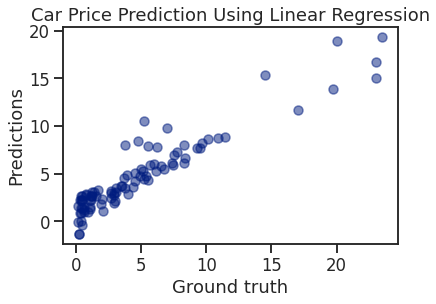

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Car Price Prediction Using Linear Regression');

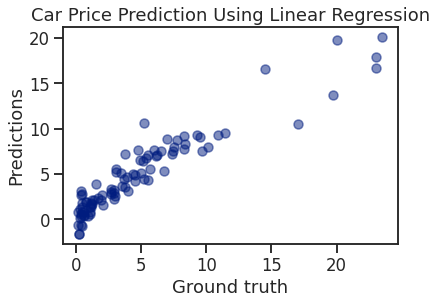

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test_ohc, y_test_ohc_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Car Price Prediction Using Linear Regression');

Lasso

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [130]:
data.head()

,Year,Selling_Price,Present_Price,Driven_kms
0,2014,3.35,5.59,27000
1,2013,4.75,9.54,43000
2,2017,7.25,9.85,6900
3,2011,2.85,4.15,5200
4,2014,4.60,6.87,42450


In [131]:
data_ohc.head()

,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type_0,Fuel_Type_1,Fuel_Type_2,Selling_type_0,Selling_type_1,Transmission_0,Transmission_1
0,2014,3.35,5.59,27000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,2013,4.75,9.54,43000,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2017,7.25,9.85,6900,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,2011,2.85,4.15,5200,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2014,4.60,6.87,42450,0.0,1.0,0.0,1.0,0.0,0.0,1.0


4.071843859867757
3.4286704639158874


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0, flags=flags)


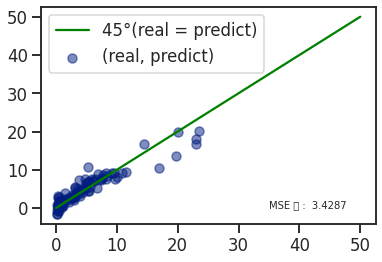

In [135]:
from sklearn.linear_model import Lasso

alpha=0.00001
lassor = Lasso(alpha)

lassor = lassor.fit(X_train, y_train)
y_test_lasso = lassor.predict(X_test)
print( mean_squared_error(y_test, y_test_lasso))

lassor_ohc = Lasso(alpha)

lassor_ohc = lassor.fit(X_train_ohc, y_train_ohc)
y_test_lasso_ohc = lassor.predict(X_test_ohc)
print( mean_squared_error(y_test_ohc, y_test_lasso_ohc))

plt.scatter(y_test_ohc,y_test_lasso_ohc, label = '(real, predict)', alpha=.5)
plt.plot(np.linspace(0,50,200), np.linspace(0,50,200), color = 'green', label = "45°(real = predict)")
plt.legend()
plt.text(y=0,x=35, s=f'MSE 값 : {mean_squared_error(y_test_ohc,y_test_lasso_ohc) : .4f}')
plt.show()


In [152]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))
alphas2 = np.array([0.0001])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
rmse_vals = [linearRegression_rmse, lassoCV_rmse]
labels = ['Linear', 'Lasso']
rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Import SGDRegressor and prepare the parameters
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD
Linear,2.017880,2.002379e+17
Lasso,2.017889,7.314735e+17
